![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

Elaborado por: Héctor David Castro, Gabriel Bolaños, Jaime Rodriguez y José Hoyos

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece.

El algoritmo predice la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import metrics
#from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras
from sklearn.model_selection import GridSearchCV

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [42]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [4]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [49]:
dataTesting['plot'][1]

"who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can ' t let go of their past ."

# Preprocesamiento de datos

## TFIDVectorizer + Stop words + Lematización de verbos

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Cargamos los stopwords en una variable
stop_words_ = list(set(stopwords.words('english')))

# Creamos un objeto WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Definición de la función que tenga como parámetro texto y devuelva una lista de lemas
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

# Vectorizamos los comentarios 
vect = TfidfVectorizer(max_features=10000,stop_words=stop_words_,analyzer=split_into_lemmas)

# Definición de variables predictoras (X)
X_dtm = vect.fit_transform(dataTraining['plot'])

# Definición de la variable respuesta (y)
X_test_dtm = vect.transform(dataTesting['plot'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielbga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gabrielbga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gabrielbga/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


En primer lugar, probamos el eliminar los stopwords o palabras más comunes y esto mejoró la predicción del modelo. Seguidamente usamos lematización, proceso en el cual cada palabra se busca en un diccionario el cual ha sido previamente calculado y este, para cada palabra, nos va a decir cuál debe ser su representación. Usamos dos tipos de lematización, una que da la definición de la función para que tenga como parámetro texto y devuelva una lista de lemas, y el otro para lematizar los verbos en cada comentario. Los mejores valores se dieron con el primero por lo que solo documentamos este. 

Para tokenizar los comentarios probamos los tokenizadores Count y TFID con valores por defecto. Los resultados mejoraron usando TFIDVectorizer en lugar de CountVectorizer. Esto es porque mientras que CountVectorizer simplemente cuenta el número de veces que aparece una palabra en un texto, TFID no solamente cuenta el número de veces sino que también evalúa que tan importante es la palabra en ese texto. Esto se hace gracias a la penalización de algunas palabras que el algoritmo considera menos importantes. Precisamente este factor es el que puede darle ventaja de TF-IDF sobre CountVectorizer, dado que, en resumen, este último pesa todas las palabras por igual, mientras que el primero ayuda a lidiar con las palabras más repetitivas y las penaliza.

En conclusión, usando la mayoría de técnicas de preprocesamiento, los mejores valores predictivos del modelo los encontramoso usando FIDVectorizer + Stop words + Lematización de verbos.

In [16]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [17]:
# Convertir la matriz dispersa en una matriz densa de NumPy de train y test
X_dtm = X_dtm.toarray()
X_test_dtm = X_test_dtm.toarray()

In [18]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [19]:
# Definición de dimensiones de entrada (variables predictoras)
dims = X_train.shape[1]
print(dims, 'input variables')

10000 input variables


In [20]:
# Definición de dimensiones de salida (variables de interés)
output_var = y_train_genres.shape[1]
print(output_var, ' output variables')

24  output variables


Finalmente, separamos la muestra en entrenamiento y evaluación para posteriormente calibrar y entrenar el modelo.

# Calibración del modelo

Las redes neuronales pueden hacer muy facilmente overfitting con los datos de entrenamiento. Por lo que hacer split con data de validación, permite calibrar hiperparametros de la red y así hacer que el algoritmo logre generalizar todos los casos posibles.

In [21]:
# Separación de datos de entrenamiento para considerar un set de validación durante entrenamiento
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train_genres, test_size=0.15, random_state=42)

Definimos una función nn_model_params que crea una red neuronal a partir de 7 diferentes parámetros a calibrar:

In [22]:
# Definición de función que crea una red neuronal a partir de diferentes parámetros (nn_model_params)
def nn_model_params(optimizer,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    loss): #Función de pérdida
    
    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()
    
    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation=activation))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = optimizer, loss=loss)
    
    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, Y_train,
              validation_data = (X_val, Y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

In [15]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'optimizer': ['adam','sgd'],
    'activation': ['sigmoid'],
    'batch_size': [64,128],
    'neurons':[64,256],
    'epochs':[20,50],
    'patience':[2,5],
    'loss':['binary_crossentropy']
}

## Método busqueda por cuadrícula (Grid Search)

La búsqueda por cuadrícula es un método de calibración de parámetros donde se considera exhaustivamente todas las combinaciones de parámetros de un conjunto determinado.

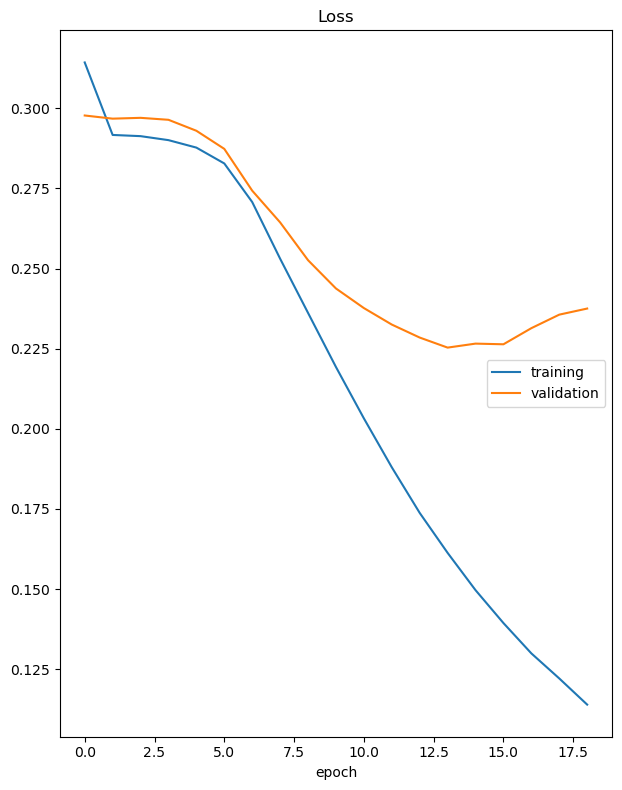

Loss
	training         	 (min:    0.114, max:    0.314, cur:    0.114)
	validation       	 (min:    0.225, max:    0.298, cur:    0.238)
71/71 [==============================] - 2s 32ms/step - loss: 0.1139 - val_loss: 0.2375
Los mejores parametros segun Grid Search: {'activation': 'sigmoid', 'batch_size': 64, 'epochs': 20, 'loss': 'binary_crossentropy', 'neurons': 256, 'optimizer': 'adam', 'patience': 5}


In [16]:
# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
gs = GridSearchCV(nn_model, nn_params, cv=3)
gs.fit(X_train, Y_train)

print('Los mejores parametros segun Grid Search:', gs.best_params_)

En resumen, dado que las redes neuronales pueden hacer facilmente overfitting, partimos la muestra de nuevo para obtener train y test en validación y poder así generalizar todos los casos posibles.

Luego definimos una función para calibrar 7 hiperparámetros de una red neuronal y poder así encontrar los mejores valores. 

Para la calibración de hiperparámetros el modelo Grindsearch, al considerar todas las combinaciones posibles, es un poco mejor que el Ramdonsearch dado que este último toma valores aleatorios y los evalúa. Por lo tanto, aunque sabemos que es más costoso computacionalmente, y lo fue, escogimos el Grindsearch para calibrar los hiperparámetros de la red neuronal. 

Los mejores valores arrojados son un modelo de activación sigmoidea, la cuál al estar sus valores entre 0 a 1 se usa especialmente para modelos en los que tenemos que predecir la probabilidad, como en este caso. 

De igual manera, 20 fueron las épocas más óptimas, que se explican como cada ciclo de corrección de propagación hacia atrás y hacia adelante para reducir las pérdida. Es curioso que aunque en la gráfica se observa que la función de pérdida no llegó a una estabilidad, los valores predictivos del modelo arrojados son decentes. 

El batchsize es 64, este es el número de ejemplos que se introducen en la red para que entrene de cada vez. Al haber escogido el menor entre 64 y 128, este entrena más rápido al tener en memoria menor cantidad de datos. 

Se usó una función de pérdida de binarycrossentropy que mide la presentación de un modelo cuyo rendimiento es la probabilidad en un rango entre 0 y 1. 

Por último, 256 neuronas fueron las más óptimas y un optimizador Adam el cuál combina las ventajas de los algoritmos RMSprop y Momentum para mejorar el proceso de aprendizaje de un modelo. 

# Entrenamiento del modelo

Entrenamos el modelo con los mejores parámetros que nos brindó la calibración usando un modelo de Grindsearch.

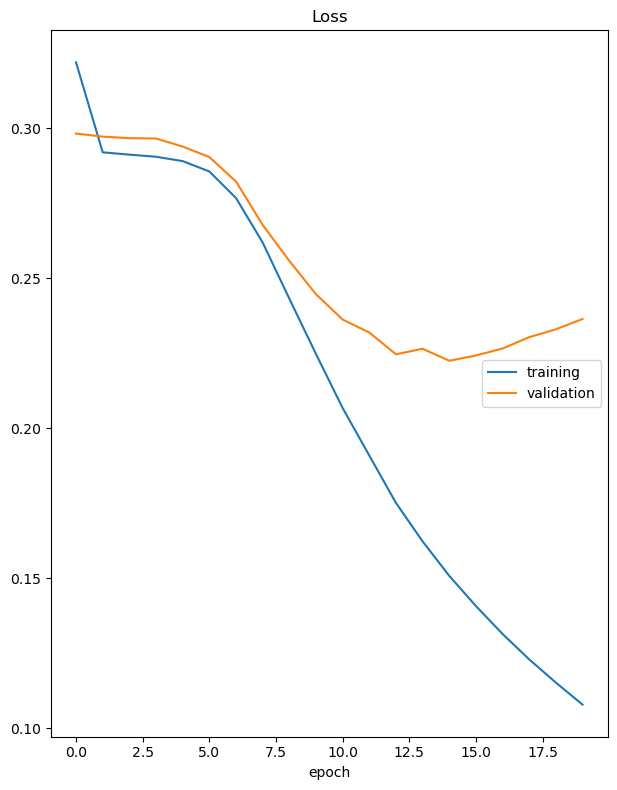

Loss
	training         	 (min:    0.108, max:    0.322, cur:    0.108)
	validation       	 (min:    0.222, max:    0.298, cur:    0.236)
141/141 [==============================] - 1s 5ms/step - loss: 0.1010 - val_loss: 0.2456


In [23]:
# Desempeño de modelo con los parametros de Grid Search
model = nn_model_params(optimizer = 'adam',
                        neurons=256,
                        batch_size=64,
                        epochs=20,
                        activation='sigmoid',
                        patience=5,
                        loss='binary_crossentropy')

model.fit(X_train, Y_train, validation_data = (X_val, Y_val), workers=6)

In [24]:
# Predicción del modelo de clasificación
y_pred_genres = model.predict(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

82/82 [==============================] - 0s 1ms/step


0.8409607383756773

Evaluamos el desempeño del modelo con la métrica de área bajo la curva AUC con un valor de 0.84, el cuál es un valor muy parecido al arrojado en la competencia de Kaggle cuando el algoritmo se enfrentó a valores nuevos. Esta métrica proporciona una medida de rendimiento en todos los umbrales de clasificación posibles.

Escogimos como modelo de predicción las redes neuronales, dado que además de ser modelos que tienen el objetivo de encontrar la función que mejor se aproxime a un conjunto de datos, son capaces de aproximar funciones complejas, no necesariamente lineales, debido a que tienen un mayor poder de predicción.

### Exportando los resultados publicados en la competencia Kaggle

In [25]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])
X_test_dtm = X_test_dtm.toarray()

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = model.predict(X_test_dtm)

106/106 [==============================] - 0s 2ms/step


In [26]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.001304,0.015312,0.001085,0.004963,0.693236,0.013064,0.000007,0.951157,0.005994,0.092338,...,0.042089,0.074507,0.000539,0.994497,0.002226,0.003242,0.001514,0.017822,0.002182,0.008527
4,0.190227,0.005835,0.000260,0.007044,0.150718,0.553395,0.008630,0.252417,0.000566,0.001437,...,0.001184,0.070758,0.000749,0.001994,0.035584,0.005954,0.004880,0.676030,0.001442,0.010459
5,0.007915,0.000658,0.000023,0.071199,0.008551,0.782740,0.002059,0.990983,0.000026,0.000238,...,0.001134,0.200261,0.000600,0.138202,0.002997,0.002058,0.003203,0.739981,0.011931,0.010830
6,0.024090,0.047267,0.000839,0.026954,0.001726,0.002094,0.001887,0.954593,0.001198,0.016273,...,0.004778,0.039318,0.000862,0.183620,0.078231,0.004850,0.002497,0.153206,0.114815,0.025219
7,0.000631,0.002032,0.001857,0.001257,0.413053,0.002452,0.001836,0.077577,0.005518,0.111056,...,0.011490,0.246173,0.000674,0.076813,0.176089,0.007689,0.000303,0.091227,0.000106,0.001596


# Disponibilización del Modelo

Para disponibilizar el modelo a través de una api, es necesario exportar los archivos binarios de los modelos entrenados. Para este caso en particular, exportamos el modelo entrenado _**'model'**_ que realizara las clasificaciones de los generos de las peliculas. Y además exportamos el modelo entrenado con los datos de training TfIdfVectorizer llamado _**'vect'**_
que utilizaremos para transformar los datos desconocidos por el modelo en el argumento de entrada _'plot'_ para que este los pueda entender y sea capaz de clasificar la información.

In [32]:
# Exportar modelo a archivo .h5 utilizando la funcion save de libreria. Evita errores comunes con la forma joblib 
model.save('clf_gender_movies.h5')

In [28]:
# Exportar vectorizador entrenado a archivo binario .pkl se puede ajustar el compress en valores mas altos # para que el archivo sea mas pequeño.
import joblib
joblib.dump(vect, 'vect_gender_movies.pkl', compress=3)

['vect_gender_movies.pkl']

Una vez con los modelos exportados implementamos los siguientes pasos para disponibilizar el modelo:

 1. Desde la consola de AWS lanzamos una Instancia **EC2** con SO **Ubuntu**.
 2. Asignamos a la instancia los grupos de seguridad adecuados que permitan trafico de entrada desde **cualquier dirección IP** (0.0.0.0/0) y las definimos de tipo **TCP** por los **puertos 22, 446, 8888 y 5000**.
 3. Utilizando el par de llaves publico-privada nos conectamos por **ssh** y subimos los archivos:
     - _**vect_gender_movies.pkl**_: Binario del modelo vectorizador.
     
     - _**clf_gender_movies.h5**_: Binario del modelo Clasificador.
     
     - _**api.py**_: Script de python que levanta una API utilizando el framework de Flask. En este se hace una definición del _PATH_ y tipo de petición (_GET_ para este caso) y de los parametros que recibirá la API tales como _'year, title, plot'_ y se agrega una descripción de ayuda al usuario para que pueda utilizarla claramente a través de la firma creada en formato swagger.json
     
     - _**model_deployment.py**_: Script de python que carga los modelos y define la funcion _**'clf_gender_movie(year, title, plot)'**_ que es llamada por la API 
 4. Levantamos la API y la dejamos ejecutandose en segundo plano utilizando el comando:
     - _**screen -d -m python3 api.py**_
     
Se puede acceder a los scripts a través del siguiente link:

https://github.com/Josehoyos26/ML-y-PLN-Grupo-26/tree/48645aa4e55aa9d0e06e219e3f4e322613a2b4a9/Proyecto%20Semana%207/scripts_disponibilizacion
     
Se puede acceder a la firma de la API a través del siguiente link:

http://ec2-35-92-115-9.us-west-2.compute.amazonaws.com:8888 

## Probando modelo disponible a través de API en un EC2 en AWS

Una vez desplegado el servicio de EC2 en AWS y cargado los scripts descritos anteriormente procedemos a hacer un par de pruebas con la API, utilizando el DNS publico de la instancia y llamandolo por medio de comandos python para obtener una respuesta tipo JSON e imprimirla.

Realizaremos tres pruebas para demostrar su funcionamiento basada en los tres primeros registros del dataset de Testing:

In [10]:
dataTesting.head(3)

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...


Es importante aclarar que para poder consumir la API los _**espacios**_ deben reemplazarse por su caracter correspondiente como _**%20**_.

In [26]:
import requests
import re

# Primera prueba ID 0
ruta_base = 'http://ec2-35-92-115-9.us-west-2.compute.amazonaws.com:8888/classifier/?'
year = 'year=' + str(dataTesting.iloc[0,:]['year'])
title = '&title=' + re.sub(' +', '%20',str(dataTesting.iloc[0,:]['title']))
plot = '&plot=' + re.sub(' +', '%20',str(dataTesting.iloc[0,:]['plot']))
url = ruta_base + year + title + plot # URL del endpoint

response = requests.get(url) # Realiza la solicitud GET

if response.status_code == 200: # Verifica si la respuesta es exitosa (código 200) 
    data = response.json() # Obtén el JSON de la respuesta
    #print(data) # Imprime el JSON
else:
    data = "Error"
    #print(f'Error al realizar la solicitud: {response.status_code}')

print(dataTesting.iloc[0,:])
data

year                                                  1999
title                                  Message in a Bottle
plot     who meets by fate ,  shall be sealed by fate ....
Name: 1, dtype: object


[{'p_Action': 0.0013035286,
  'p_Adventure': 0.0153117254,
  'p_Animation': 0.0010849548,
  'p_Biography': 0.0049630883,
  'p_Comedy': 0.6932355165,
  'p_Crime': 0.0130637195,
  'p_Documentary': 6.5982e-06,
  'p_Drama': 0.9511572719,
  'p_Family': 0.0059937723,
  'p_Fantasy': 0.0923378989,
  'p_Film-Noir': 0.0099457996,
  'p_History': 0.002210544,
  'p_Horror': 0.004236877,
  'p_Music': 0.0096301688,
  'p_Musical': 0.0420891307,
  'p_Mystery': 0.0745066851,
  'p_News': 0.0005386724,
  'p_Romance': 0.9944974184,
  'p_Sci-Fi': 0.0022259071,
  'p_Short': 0.003241861,
  'p_Sport': 0.0015135703,
  'p_Thriller': 0.0178215913,
  'p_War': 0.0021817936,
  'p_Western': 0.0085275071}]

In [27]:
# Segunda prueba ID 1
ruta_base = 'http://ec2-35-92-115-9.us-west-2.compute.amazonaws.com:8888/classifier/?'
year = 'year=' + str(dataTesting.iloc[1,:]['year'])
title = '&title=' + re.sub(' +', '%20',str(dataTesting.iloc[1,:]['title']))
plot = '&plot=' + re.sub(' +', '%20',str(dataTesting.iloc[1,:]['plot']))
url = ruta_base + year + title + plot # URL del endpoint

response = requests.get(url) # Realiza la solicitud GET

if response.status_code == 200: # Verifica si la respuesta es exitosa (código 200) 
    data = response.json() # Obtén el JSON de la respuesta
    #print(data) # Imprime el JSON
else:
    data = "Error"
    #print(f'Error al realizar la solicitud: {response.status_code}')
    
print(dataTesting.iloc[1,:])
data

year                                                  1978
title                                     Midnight Express
plot     the true story of billy hayes ,  an american c...
Name: 4, dtype: object


[{'p_Action': 0.1902271658,
  'p_Adventure': 0.005834498,
  'p_Animation': 0.000260144,
  'p_Biography': 0.0070442497,
  'p_Comedy': 0.1507183015,
  'p_Crime': 0.5533950925,
  'p_Documentary': 0.0086294999,
  'p_Drama': 0.252417475,
  'p_Family': 0.0005664698,
  'p_Fantasy': 0.0014370566,
  'p_Film-Noir': 0.0096444543,
  'p_History': 0.0021165935,
  'p_Horror': 0.0423066318,
  'p_Music': 0.0022852526,
  'p_Musical': 0.0011836416,
  'p_Mystery': 0.0707583129,
  'p_News': 0.0007491773,
  'p_Romance': 0.001993811,
  'p_Sci-Fi': 0.0355842449,
  'p_Short': 0.0059541953,
  'p_Sport': 0.0048801024,
  'p_Thriller': 0.6760299206,
  'p_War': 0.0014415757,
  'p_Western': 0.0104586538}]

In [28]:
# Tercera prueba ID 2
ruta_base = 'http://ec2-35-92-115-9.us-west-2.compute.amazonaws.com:8888/classifier/?'
year = 'year=' + str(dataTesting.iloc[2,:]['year'])
title = '&title=' + re.sub(' +', '%20',str(dataTesting.iloc[2,:]['title']))
plot = '&plot=' + re.sub(' +', '%20',str(dataTesting.iloc[2,:]['plot']))
url = ruta_base + year + title + plot # URL del endpoint

response = requests.get(url) # Realiza la solicitud GET

if response.status_code == 200: # Verifica si la respuesta es exitosa (código 200) 
    data = response.json() # Obtén el JSON de la respuesta
    #print(data) # Imprime el JSON
else:
    data = "Error"
    #print(f'Error al realizar la solicitud: {response.status_code}')

print(dataTesting.iloc[2,:])
data

year                                                  1996
title                                          Primal Fear
plot     martin vail left the chicago da ' s office to ...
Name: 5, dtype: object


[{'p_Action': 0.0079146754,
  'p_Adventure': 0.0006577424,
  'p_Animation': 2.29112e-05,
  'p_Biography': 0.0711987689,
  'p_Comedy': 0.0085507547,
  'p_Crime': 0.7827395201,
  'p_Documentary': 0.0020590061,
  'p_Drama': 0.9909827113,
  'p_Family': 2.61865e-05,
  'p_Fantasy': 0.000237862,
  'p_Film-Noir': 0.1439110339,
  'p_History': 0.013325097,
  'p_Horror': 0.0022851634,
  'p_Music': 0.0069345362,
  'p_Musical': 0.0011340702,
  'p_Mystery': 0.2002615035,
  'p_News': 0.0006001942,
  'p_Romance': 0.1382018477,
  'p_Sci-Fi': 0.0029973299,
  'p_Short': 0.0020578592,
  'p_Sport': 0.0032033406,
  'p_Thriller': 0.7399813533,
  'p_War': 0.0119306389,
  'p_Western': 0.0108298128}]

# Conclusiones

En primer lugar, para el preprocesamiento los mejores resultados fueron la combinación de eliminar los stopwords o palabras más comunes, lematización para conocer la representación de cada palabra usando un diccionario y TFIDVectorizer que ayuda a lidiar con las palabras más repetitivas y las penaliza.

En la calibración de parámetros fue importante volver a dividir la muestra para combatir el overfitting y poder generalizar todos los casos posibles. Igualmente, aunque conocemos que ramdonsearch es un calibrador de hiperparámetros más rápido, preferimos usar Grindsearch dado que este evalúa todos los casos posibles. Sin embargo, sabemos que el valor computacional es muy alto y en próximos estudios es preciso evaluar estos métodos de nuevo, con más valores para mejorar la predicción del modelo. Esto se pudo observar claramente en la gráfica donde la función de pérdida no llegó a una estabilidad clara.

Escogimos como modelo de predicción las redes neuronales dado que tienen un mayor poder de predicción y son capaces de aproximar funciones complejas no necesariamente lineales.

El valor predictivo del modelo en entrenamiento y cuando se enfrentó a valores nuevos en la competencia de Kaggle fue muy parecido, casi igual. Por lo que se entiende que see combatió el problema de overfitting.

Por último, es importante resaltar que los valores predictivos del modelo se pueden mejorar en estudios futuros a través del ejercicio iterativo. Esto es calibrando mejor los hiperparámetros dado que por cuestiones de tiempo y que hacerlo es computacionalmente alto, no se pudo profundizar en este estudio. 